In [21]:
# Import functions and libraries

import numpy as np
import matplotlib.pyplot as plt
import pyaudio, threading,time, sys, threading,time, serial
import queue as Queue
from numpy import pi, sin, zeros, r_
from scipy import signal
from scipy import misc
from scipy import ndimage
import copy
# from rtlsdr import RtlSdr
import sounddevice as sd
# import RPi.GPIO as GPIO
import pywt
%matplotlib inline
import bitarray, time, urllib, ssl
from scipy import signal, integrate
from math import gcd
from functools import reduce
from numpy.random import rand, randn
from numpy import ones,zeros, pi, cos, exp, sign
import copy

In [22]:
# function to compute average power spectrum
def avgPS( x, N=256, fs=1):
    M = (len(x)//N)
    x_ = np.reshape(x[:M*N],(M,N)) * np.hamming(N)[None,:]
    X = np.fft.fftshift(np.fft.fft(x_,axis=1),axes=1)
    return r_[-N/2.0:N/2.0]/N*fs, np.mean(abs(X)**2,axis=0)


# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60, fig = None) :
    eps = 10.0**(-dbf/20.0)  # minimum signal
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( (abs( y ) / y_max)*(1-eps) + eps )
    
    # rescale image intensity to 256
    img = 256*(y_log + dbf)/dbf - 1
    
    fig=plt.figure(figsize=(16,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()
    plt.show()
    return fig


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = np.isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = np.append(x,zeros(-lx+nt*m))
    x = x.reshape((m//2,nt*2), order='F')
    x = np.concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),np.ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * np.hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m//2,:],dbf=dbf)
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

In [3]:
GPIO.setmode(GPIO.BOARD)

NameError: name 'GPIO' is not defined

In [ ]:
PTT = 12
GPIO.setup(PTT, GPIO.OUT, initial = GPIO.HIGH)

In [4]:
fs = 240000
fc =  443630000
sdr = RtlSdr()
sdr.sample_rate = fs    # sampling rate
sdr.gain = gaincalib
sdr.center_freq = fc
sdr.set_freq_correction(int(ppmcalib))


YOURCALLSIGN="KM6QGJ"
audio_gain = 1


callsign = text2Morse(YOURCALLSIGN,850,48000,75e-3)*audio_gain
callsign = np.concatenate((np.zeros(4800),callsign))                      



GPIO.output(PTT, GPIO.LOW)
sd.play(callsign,samplerate=48000,device=5,  blocking=False)
y = sdr.read_samples(256000*7)
sdr.close()
GPIO.output(PTT, GPIO.HIGH)

NameError: name 'RtlSdr' is not defined

In [99]:
im = misc.imread('images/calBlue.tiff')
# print(im)
dims = im.shape[0:2]
def flattenImage(img): 
    r = img[:,:,0].flatten()
    g = img[:,:,1].flatten()
    b = img[:,:,2].flatten()
    bits = np.hstack((r,g,b))
    return r,g,b,bits
r,g,b,bits = flattenImage(im)
# print(r)

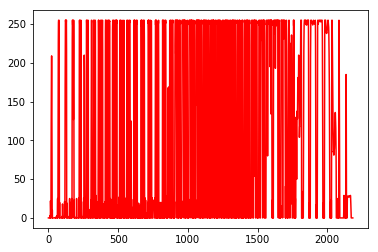

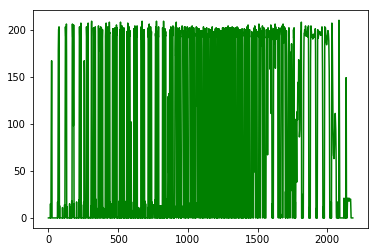

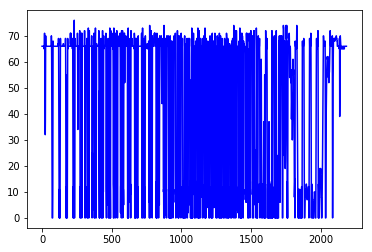

In [100]:
plt.plot(r, color='red')
plt.show()
plt.plot(g, color='green')
plt.show()
plt.plot(b, color = 'blue')
plt.show()

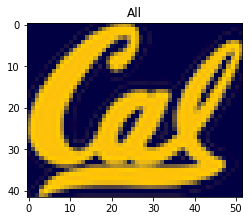

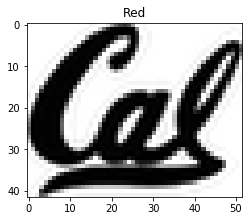

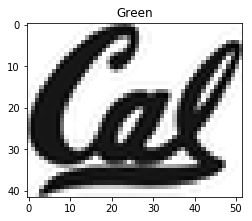

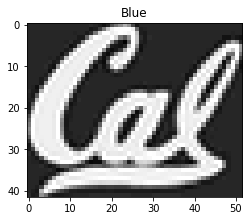

In [101]:
width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('All')
plt.imshow(im, cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Red')
plt.imshow(r.reshape(dims), cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Green')
plt.imshow(g.reshape(dims), cmap="Greys")
plt.show()

width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.title('Blue')
plt.imshow(b.reshape(dims), cmap="Greys")
plt.show()

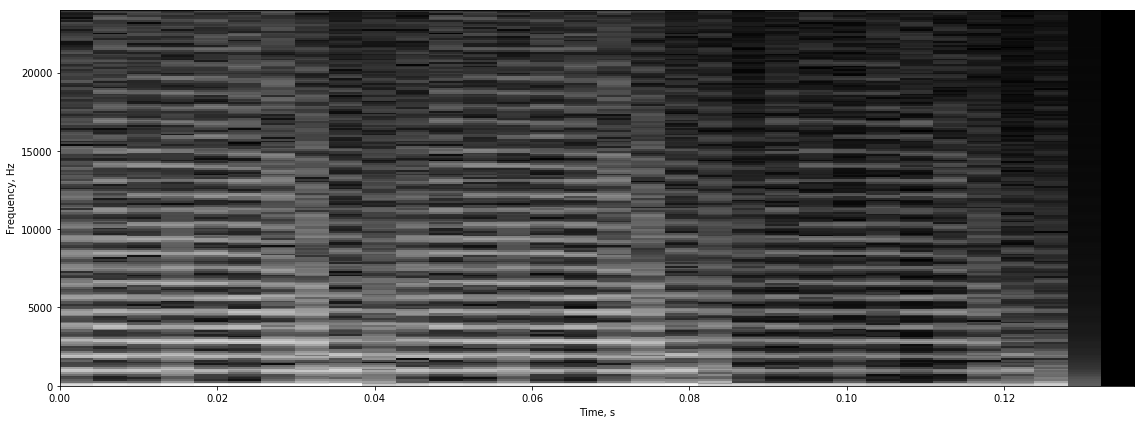

In [102]:
tt, ff, xmf = myspectrogram_hann_ovlp(bits[:], 432, 48000, 0)

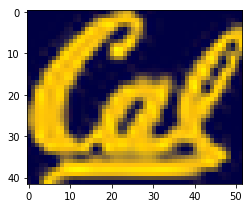

In [103]:
def downsample_image(im, L):
    dIm = im[::L, ::L, :]
#     print(im, dIm)
#     print(len(im), len(dIm))
    r,g,b,bits = flattenImage(dIm)
#     print(r,g,b)
    return r,g,b,bits

def recover_image(bits, dims, M):
    r, g, b = bits[:len(bits)//3], bits[len(bits)//3:2*len(bits)//3], bits[2*len(bits)//3:]
#     print(len(r), dims)
    rgb_bits = np.column_stack((r,g,b))[None,:,:]
    rgb_bits = rgb_bits.reshape(tuple([dim//M for dim in dims]+[3]))
#     print(rgb_bits)
    return ndimage.zoom(rgb_bits, (M,M,1))

_,_,_,bits = downsample_image(im, 2)
dims = im.shape[:2]
duIm = recover_image(bits, dims, 2)
width, height = plt.figaspect(.2)
plt.figure(figsize = (width, height))
plt.imshow(duIm)
plt.show()

In [104]:
def psnr(im1, im2):
    MSE = 0
    dims = im.shape
    for i in range(dims[0]):
        for j in range(dims[1]):
            for c in range(dims[2]):
                MSE += pow(im1[i][j][c]-im2[i][j][c], 2)/np.prod(dims)
#                 print(im1[i][j][c],im2[i][j][c])
#     MSE *= 1/np.prod(dims)
    return 10*np.log10(255*255/MSE)

In [105]:
psnr(im, duIm)

C:\Users\liget_4sn\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


4.4591616884516441

In [106]:
def im2Channels(im):
    return im[:,:,0], im[:,:,1], im[:,:,2]
def channels2Im(ch1,ch2,ch3):
    return np.dstack((ch1,ch2,ch3))

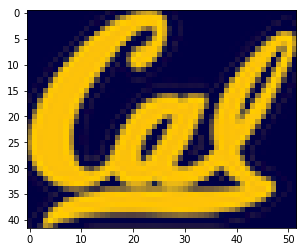

In [107]:
plt.imshow(im)

# im = np.float64(im)

A = np.array([[.299, .587, .114],
                 [-.168736, -.331264, .5],
                 [.5, -.418688,-.081312]])
c = np.float64(np.array([0,128,128]))

aa = rgb2ycbcr(im)

row,col,color = im.shape

bb = np.transpose(A.dot(np.transpose(im.reshape((row*col,3))))).reshape((row,col,3)) + c.reshape((1,1,3))

A_inv = np.array([[1, 0, 1.402],
                     [1, -.344136, -.714136],
                     [1, 1.772, 0]])
c_inv = np.float64(np.array([0,128,128]))

cc = np.clip(np.round(A_inv.dot((bb.reshape((row*col,3)) - c_inv.reshape((1,3))).T).T.reshape((row,col,3))),0,255)
plt.imshow(np.uint8(cc))

In [108]:
def rgb2ycbcr(im):
    def transform(rgb):
        A = np.array([[.299, .587, .114],
                 [-.168736, -.331264, .5],
                 [.5, -.418688,-.081312]])
        c = np.array([0,128,128])
        ycbcr = np.dot(A, rgb)
        ycbcr += c
        return ycbcr
    ycbcr_im = np.apply_along_axis(transform, 2, im)
    return ycbcr_im
def ycbcr2rgb(im):
    def transform(ycbcr):
        A = np.array([[1, 0, 1.402],
                     [1, -.344136, -.714136],
                     [1, 1.772, 0]])
        c = np.array([0,128,128])
#         print('=================')
#         print(ycbcr)
        rgb = ycbcr - c
#         print(rgb)
        rgb = np.dot(A, rgb)
#         print(A, rgb)
        return np.round(rgb)
    rgb_im = np.uint8(np.apply_along_axis(transform, 2, im))
    return rgb_im

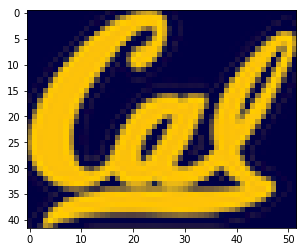

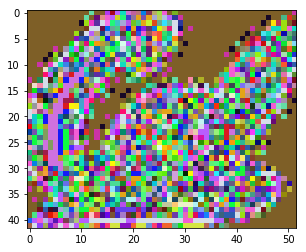

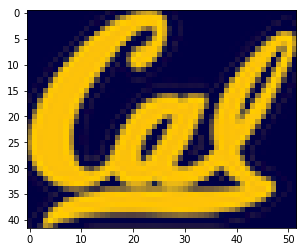

In [109]:
# print(rgb2ycbcr(im))
# im = [[] for i in ]
# print(im)
plt.imshow(im)
plt.show()
y_im = rgb2ycbcr(im)
plt.imshow(y_im)
plt.show()
rgb_im = ycbcr2rgb(y_im)
plt.imshow(rgb_im)
plt.show()

In [110]:
def r2ytransform(rgb):
        A = np.array([[.299, .587, .114],
                 [-.168736, -.331264, .5],
                 [.5, -.418688,-.081312]])
        c = np.array([0,128,128])
        ycbcr = np.dot(A, rgb)
        ycbcr += c
        return ycbcr
def y2rtransform(ycbcr):
        A = np.array([[1, 0, 1.402],
                     [1, -.344136, -.714136],
                     [1, 1.772, 0]])
        c = np.array([0,128,128])
        rgb = ycbcr - c
        rgb = np.dot(A, rgb)
        return np.round(rgb)

In [111]:
print(r2ytransform([0,0,66]))
print(y2rtransform([7.524,161.,        122.633408]))

[   7.524     161.        122.633408]
[  0.  -0.  66.]


In [112]:
#color transform
ycbcr_im =im2Channels(rgb2ycbcr(im))

In [86]:

N = 8
# for i in range(len(r)//N):
#     for j in range(im.shape[1]//N):
#         r_sec = r[i*N:i*N+N,j*N:j*N+N]-128
#         plt.imshow(r_sec, cmap='Greys')
#         plt.show()
#         r_wvlt = pywt.dwt2(r_sec, 'db9')
#         print(r_wvlt)
#         f, axarr = plt.subplots(2,2, sharex=True, sharey=True)
#         axarr[0,0].imshow(r_wvlt[0])
#         axarr[0,1].imshow(r_wvlt[1][0])
#         axarr[1,0].imshow(r_wvlt[1][1])
#         axarr[1,1].imshow(r_wvlt[1][2])
#         plt.imshow(r_wvlt[1][0], cmap='Greys')
#         plt.plot(r_wvlt[1][0].flatten())
#         plt.imshow(r_wvlt[1][0], cmap = "Greys")
#         plt.imshow(r_wvlt[1][0])
#         plt.imshow(r_wvlt[1][1])
#         plt.imshow(r_wvlt[1][2])
#         plt.show()

In [114]:
#db9 wavelet transform
ycbcr_w = []
wavelet = 'db9'
max_level = 2
for ch in ycbcr_im:
    chw = pywt.wavedec2(ch-128, wavelet, level=max_level)
    ycbcr_w.append(chw)
#     print(chw)

ValueError: Level value of 2 is too high.  Maximum allowed is 1.

In [19]:
def plot_wavelets(imw):
    for chw in imw:
        for i in range(len(chw)):
            if i == 0:
                plt.title('Approximation')
                plt.imshow(chw[0], cmap='Greys')
                plt.show()
            else:
                for j in range(len(chw[i])):
                    plt.title('Wavelet level = ' + str(i) + ', component ' + str(j))
                    plt.imshow(chw[i][j], cmap='Greys')
                    plt.show()

In [20]:
#threshold wavelet coeffs
thresh = 25
for channel in ycbcr_w:
    for level in channel:
        for arr in level:
            arr = np.where(arr<thresh, 0, arr)
plot_wavelets(ycbcr_w)

#quantize